<a href="https://colab.research.google.com/github/Dharshan4038/Invoice_Purchase_Order_Match/blob/main/weight_inv_po.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence_transformers transformers datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sentence_transformers import CrossEncoder, InputExample
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments
from torch import nn

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Invoice_PO_Match/validation_formatted 1.csv')
df.head()

,invoice_id,invoice_desc,PO_line_desc,true_mapping
0,INV-49266647,"['25103 ICE CREAM MANGO SORBETTO TRAY', 'ICE C...","['ICE CREAM MANGO SORBETTO TRAY', 'ICE CREAM G...",[{'25103 ICE CREAM MANGO SORBETTO TRAY': 'ICE ...
1,INV-49266660,"['ICE CREAM GELATO MACKINAC FDGE 3/5LT', 'ICE ...","['ICE CREAM GELATO MACKINAC FDGE', 'ICE CREAM ...",[{'ICE CREAM GELATO MACKINAC FDGE 3/5LT': 'ICE...
2,INV-49266724,['Scotch-Brite Quick Clean Griddle Liquid 700-...,"['CLEANER GRL QUICKCLEAN PCKT', 'PAD SCOUR COM...",[{'Scotch-Brite Quick Clean Griddle Liquid 700...
3,INV-49267382,"['Jersey Mikes Mini Wheat Sub', 'Jersey Mikes'...","['ROLL MINI WHEAT SUB', 'ROLL MINI WHT SUB', '...",[{'Jersey Mikes Mini Wheat Sub': 'ROLL MINI WH...
4,INV-49267510,"['CASES BEEF GRND CHUCK PATTY 4oz', '14 CASES ...","['BEEF GRND CHUCK PATTY 4OZ', 'BEEF GRND THICK...",[{'CASES BEEF GRND CHUCK PATTY 4oz': 'BEEF GRN...


In [ ]:
invoice = df["invoice_desc"]
purchase_order = df["PO_line_desc"]
true_mapping = df["true_mapping"]

In [ ]:
import ast
for i in range(len(invoice)):
    invoice[i] = ast.literal_eval(invoice[i])
    purchase_order[i] = ast.literal_eval(purchase_order[i])
    true_mapping[i] = eval(true_mapping[i])

In [ ]:
# Create a DataFrame with all possible invoice/purchase order pairs
final_data = []
for invoice_list, po_list, mapping in zip(invoice, purchase_order, true_mapping):
    mapping_dict = {list(d.keys())[0]: list(d.values())[0] for d in mapping}
    for invoice in invoice_list:
        for po in po_list:
            label = 1 if mapping_dict.get(invoice) == po else 0
            final_data.append([invoice, po, label])

In [ ]:
df = pd.DataFrame(final_data, columns=['Invoice', 'Purchase Order', 'Label'])

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
model_name = "cross-encoder/stsb-roberta-base"
cross_encoder = CrossEncoder(model_name, num_labels=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Tokenizer for the CrossEncoder model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Prepare the data for InputExample format
train_examples = [InputExample(texts=[row['Invoice'], row['Purchase Order']], label=row['Label']) for _, row in train_df.iterrows()]
val_examples = [InputExample(texts=[row['Invoice'], row['Purchase Order']], label=row['Label']) for _, row in val_df.iterrows()]

In [ ]:
# Define a custom data collator
def custom_collate_fn(features):
    # Extract texts and labels
    texts = [feature.texts for feature in features]
    labels = [feature.label for feature in features]

    # Tokenize texts (pair-wise)
    tokenized_texts = tokenizer(
        [f"{pair[0]} {pair[1]}" for pair in texts],  # Combine the invoice and purchase order as one input
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    return {
        "input_ids": tokenized_texts['input_ids'],
        "attention_mask": tokenized_texts['attention_mask'],
        "labels": torch.tensor(labels, dtype=torch.float)
    }

In [ ]:
# Define class weights (adjust for class imbalance)
class_counts = df['Label'].value_counts()
total_samples = len(df)
class_weights = [total_samples / class_counts[0], total_samples / class_counts[1]]
class_weights = torch.tensor(class_weights).to(cross_encoder.model.device)

In [ ]:
class_weights

tensor([ 1.0845, 12.8367], dtype=torch.float64)

In [ ]:
class WeightedLossCrossEncoder(CrossEncoder):
    def __init__(self, *args, **kwargs):
        super(WeightedLossCrossEncoder, self).__init__(*args, **kwargs)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    def forward(self, input_ids, attention_mask, labels):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze()
        loss = self.loss_fn(logits, labels)
        return loss, logits

In [ ]:
cross_encoder = WeightedLossCrossEncoder(model_name, num_labels=1)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01
)

# Create a Trainer instance
trainer = Trainer(
    model=cross_encoder.model,
    args=training_args,
    train_dataset=train_examples,
    eval_dataset=val_examples,
    data_collator=custom_collate_fn
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# trainer.train()

Epoch,Training Loss,Validation Loss
1,0.024000,0.020787
2,0.017300,0.017808
3,0.011600,0.014721
4,0.008600,0.013624


TrainOutput(global_step=15808, training_loss=0.016993596229837975, metrics={'train_runtime': 2802.4646, 'train_samples_per_second': 90.232, 'train_steps_per_second': 5.641, 'total_flos': 4593496477589148.0, 'train_loss': 0.016993596229837975, 'epoch': 4.0})

In [ ]:
output_dir = "/content/drive/MyDrive/Invoice_PO_Match/saved_model"
cross_encoder.model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to /content/drive/MyDrive/Invoice_PO_Match/saved_model


In [ ]:
model_name = "/content/drive/MyDrive/Invoice_PO_Match/saved_model"
cross_encoder = CrossEncoder(model_name, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
val_dataloader = DataLoader(val_examples, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)

In [ ]:
# Set the model to evaluation mode
cross_encoder.model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
# Make predictions on the validation set
val_predictions = []
val_labels = []
val_logits = []  # Store logits for ROC-AUC calculation

# Use a threshold to classify predictions
threshold = 0.5

# Evaluate predictions
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch["input_ids"].to(cross_encoder.model.device)
        attention_mask = batch["attention_mask"].to(cross_encoder.model.device)
        labels = batch["labels"].to(cross_encoder.model.device)

        # Forward pass
        outputs = cross_encoder.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze().cpu().numpy()

        # Save logits for ROC-AUC
        val_logits.extend(logits)  # Ensure logits are appended correctly

        # Apply threshold to logits for binary classification
        predictions = (logits >= threshold).astype(int)
        val_predictions.extend(predictions)
        val_labels.extend(labels.cpu().numpy())

# Check the lengths of val_labels and val_logits
print(f"Number of labels: {len(val_labels)}, Number of logits: {len(val_logits)}")

Number of labels: 15805, Number of logits: 15805


In [ ]:
# Calculate metrics
accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
roc_auc = roc_auc_score(val_labels, val_logits)

In [ ]:
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")
print(f"Validation ROC-AUC: {roc_auc:.4f}")

Validation Accuracy: 0.9860
Validation Precision: 0.9279
Validation Recall: 0.8906
Validation F1 Score: 0.9089
Validation ROC-AUC: 0.9911


Confusion Matrix:
[[14476    86]
 [  136  1107]]


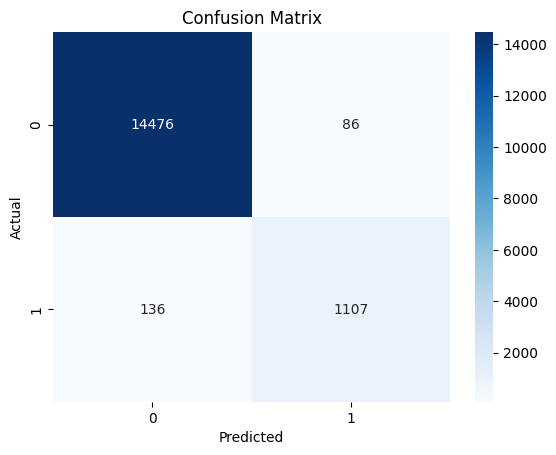

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Load the trained model and tokenizer
model_name = "/content/drive/MyDrive/Invoice_PO_Match/saved_model"  # replace with your model path
cross_encoder = CrossEncoder(model_name, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Set model to evaluation mode
cross_encoder.model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
import torch
import numpy as np

# Create a function to compute similarity and map invoices to purchase orders with one-to-one mapping
def map_invoices_to_purchase_orders(invoices, purchase_orders, cross_encoder, tokenizer):
    results = []

    # Copy the lists to keep track of unassigned invoices and purchase orders
    remaining_invoices = invoices.copy()
    remaining_purchase_orders = purchase_orders.copy()

    while remaining_invoices and remaining_purchase_orders:
        best_mapping = None
        best_score = -np.inf  # Initialize with a very low score

        # Iterate over all combinations of remaining invoices and purchase orders
        for invoice in remaining_invoices:
            for po in remaining_purchase_orders:
                pair = [invoice, po]

                # Tokenize and encode the input
                tokenized_pair = tokenizer(pair[0], pair[1], padding=True, truncation=True, return_tensors="pt")
                input_ids = tokenized_pair['input_ids'].to(cross_encoder.model.device)
                attention_mask = tokenized_pair['attention_mask'].to(cross_encoder.model.device)

                # Perform forward pass and get logits (similarity score)
                with torch.no_grad():
                    logits = cross_encoder.model(input_ids=input_ids, attention_mask=attention_mask)
                    score = logits.logits.squeeze().item()  # Get the similarity score

                # Update the best mapping if the score is higher
                if score > best_score:
                    best_score = score
                    best_mapping = (invoice, po)

        # Add the best mapping to the results
        if best_mapping:
            results.append({best_mapping[0]: best_mapping[1]})

            # Remove the mapped invoice and purchase order from the remaining lists
            remaining_invoices.remove(best_mapping[0])
            remaining_purchase_orders.remove(best_mapping[1])

    return results

In [ ]:
# Sample invoices
invoices = [
    "Invoice #12345: 10 units of 'Wireless Bluetooth Headphones' with noise cancellation technology. Price per unit: $120. Date: 2024-09-25.",
    "Invoice #67890: 50 units of '32GB USB Flash Drives' (Brand: Kingston). Price per unit: $8.50. Date: 2024-10-01.",
    "Invoice #54321: 200 units of 'Laptop Stands' made of aluminum alloy with adjustable height. Price per unit: $25. Date: 2024-08-15.",
    "Invoice #98765: 15 units of 'Gaming Keyboards' with RGB lighting and mechanical switches. Price per unit: $75. Date: 2024-09-30.",
    "Invoice #13579: 100 units of 'Noise-Cancelling Earbuds' (Brand: Sony). Price per unit: $50. Date: 2024-09-10."
]

# Sample purchase orders
purchase_orders = [
    "PO #A1001: 10x 'Wireless Bluetooth Headphones' - Brand: Bose. Order date: 2024-09-24. Delivery expected by: 2024-10-01.",
    "PO #B2002: 50x '32GB USB Flash Drives' - Kingston. Order date: 2024-09-29. Delivery expected by: 2024-10-05.",
    "PO #C3003: 150x 'Laptop Stands' (adjustable aluminum model). Order date: 2024-08-13. Delivery expected by: 2024-08-20.",
    "PO #D4004: 20x 'Gaming Keyboards' with mechanical switches and RGB backlighting. Order date: 2024-09-28. Delivery expected by: 2024-10-04.",
    "PO #E5005: 100x 'Noise-Cancelling Earbuds' - Sony. Order date: 2024-09-09. Delivery expected by: 2024-09-15."
]

In [ ]:
mapped_results = map_invoices_to_purchase_orders(invoices, purchase_orders, cross_encoder, tokenizer)

# Output the results
print("Mapped Invoices to Purchase Orders:")
for mapping in mapped_results:
    print(mapping)

Mapped Invoices to Purchase Orders:
{"Invoice #67890: 50 units of '32GB USB Flash Drives' (Brand: Kingston). Price per unit: $8.50. Date: 2024-10-01.": "PO #B2002: 50x '32GB USB Flash Drives' - Kingston. Order date: 2024-09-29. Delivery expected by: 2024-10-05."}
{"Invoice #12345: 10 units of 'Wireless Bluetooth Headphones' with noise cancellation technology. Price per unit: $120. Date: 2024-09-25.": "PO #A1001: 10x 'Wireless Bluetooth Headphones' - Brand: Bose. Order date: 2024-09-24. Delivery expected by: 2024-10-01."}
{"Invoice #13579: 100 units of 'Noise-Cancelling Earbuds' (Brand: Sony). Price per unit: $50. Date: 2024-09-10.": "PO #E5005: 100x 'Noise-Cancelling Earbuds' - Sony. Order date: 2024-09-09. Delivery expected by: 2024-09-15."}
{"Invoice #54321: 200 units of 'Laptop Stands' made of aluminum alloy with adjustable height. Price per unit: $25. Date: 2024-08-15.": "PO #C3003: 150x 'Laptop Stands' (adjustable aluminum model). Order date: 2024-08-13. Delivery expected by: 2024

In [ ]:
import pandas as pd
import ast
import torch

# Load the original CSV containing the invoice and purchase order data
df = pd.read_csv('/content/drive/MyDrive/Invoice_PO_Match/validation_formatted 1.csv')

# Extract the necessary columns: 'invoice_id', 'invoice_desc', 'PO_line_desc', 'true_mapping'
df = df[['invoice_id', 'invoice_desc', 'PO_line_desc', 'true_mapping']]

# Parse the 'invoice_desc', 'PO_line_desc', and 'true_mapping' columns from strings to lists/dictionaries
for i in range(len(df)):
    df.at[i, 'invoice_desc'] = ast.literal_eval(df.at[i, 'invoice_desc'])
    df.at[i, 'PO_line_desc'] = ast.literal_eval(df.at[i, 'PO_line_desc'])
    df.at[i, 'true_mapping'] = ast.literal_eval(df.at[i, 'true_mapping'])

In [ ]:
def map_invoices_to_purchase_orders(invoices, purchase_orders, cross_encoder, tokenizer):
    results = []
    remaining_invoices = invoices.copy()
    remaining_purchase_orders = purchase_orders.copy()

    while remaining_invoices and remaining_purchase_orders:
        best_mapping = None
        best_score = -float('inf')  # Initialize with a very low score

        for invoice in remaining_invoices:
            for po in remaining_purchase_orders:
                pair = [invoice, po]
                tokenized_pair = tokenizer(pair[0], pair[1], padding=True, truncation=True, return_tensors="pt")
                input_ids = tokenized_pair['input_ids'].to(cross_encoder.model.device)
                attention_mask = tokenized_pair['attention_mask'].to(cross_encoder.model.device)

                with torch.no_grad():
                    logits = cross_encoder.model(input_ids=input_ids, attention_mask=attention_mask)
                    score = logits.logits.squeeze().item()

                if score > best_score:
                    best_score = score
                    best_mapping = (invoice, po)

        if best_mapping:
            results.append({best_mapping[0]: best_mapping[1]})
            remaining_invoices.remove(best_mapping[0])
            remaining_purchase_orders.remove(best_mapping[1])

    return results

In [ ]:
# Function to compute and add the 'model_output' for each row
def compute_model_output(df, cross_encoder, tokenizer):
    model_output = []

    for i, row in df.iterrows():
        invoices = row['invoice_desc']
        purchase_orders = row['PO_line_desc']
        print(i)
        # Use the map_invoices_to_purchase_orders function to get the mapping
        mapping_result = map_invoices_to_purchase_orders(invoices, purchase_orders, cross_encoder, tokenizer)
        print(mapping_result)
        # Append the mapping result to the list
        model_output.append(mapping_result)

    # Add the 'model_output' column to the dataframe
    df['model_output'] = model_output

    return df

In [ ]:
# Compute the model output for the dataframe
df_with_model_output = compute_model_output(df, cross_encoder, tokenizer)

# Save the dataframe to a CSV file
output_csv_path = '/content/drive/MyDrive/Invoice_PO_Match/mapped_invoices_po_output.csv'
df_with_model_output.to_csv(output_csv_path, index=False)

print(f"Model output saved to: {output_csv_path}")

0
[{'ICE CREAM COOKIE%CRM DUTCH FUD 3/5LT': 'ICE CREAM COOKIE%CRM DUTCH FUD'}, {'25103 ICE CREAM MANGO SORBETTO TRAY': 'ICE CREAM MANGO SORBETTO TRAY'}, {'ICE CREAM SORBET LEMONCELLO 3/5 LT': 'ICE CREAM SORBET LEMONCELLO'}, {'ICE CREAM GELATO CHOC ND VEGAN 3/5LT': 'ICE CREAM GELATO CHOC ND VEGAN'}, {'ICE CREAM GELATO MACKINAC FDGE 3/5LT': 'ICE CREAM GELATO MACKINAC FDGE'}, {'ICE CREAM GELATO BUTR PECAN 3 / 5LT': 'ICE CREAM GELATO BUTR PECAN'}]
1
[{'ICE CREAM CREME DE MINTHE CHIP 3/5LT': 'ICE CREAM CREME DE MENTHE CHIP'}, {'ICE CREAM GELATO PEANUT BTR 3/5LT': 'ICE CREAM GELATO PEANUT BTR'}, {'ICE CREAM GELATO MACKINAC FDGE 3/5LT': 'ICE CREAM GELATO MACKINAC FDGE'}, {'ICE CREAM GELATO RD VELVET 3/5LT': 'ICE CREAM GELATO RD VELVET'}, {'ICE CREAM GELATO STRAW FRSH 3/5LT': 'ICE CREAM GELATO STRAW FRSH'}, {'ICE CREAM GELATO VAN BEAN 3/ 5LT': 'ICE CREAM GELATO VAN BEAN'}, {'ICE CREAM GELATO SWISS CHOC 3/ 5LT': 'ICE CREAM GELATO SWISS CHOC'}]
2
[{'Scotch-Brite General Purpose Scour Pad 96 6 in